In [ ]:
import os

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


In [3]:
!nvidia-smi

Sun Oct  4 04:45:55 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.23.05    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   61C    P8    11W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# For listening the wav file
import IPython.display as ipd
ipd.Audio('/kaggle/input/ravdess-emotional-song-audio/Actor_22/03-02-05-02-02-01-22.wav')

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import signal
from scipy.io import wavfile
# !pip install librosa
import librosa
import librosa.display
import glob
from tqdm import tqdm
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
import random

In [ ]:
# Reading the audio file
# 1012 is total number of data
# (128,275) is maximum number of dimension the spectrogram gives as output in this dataset. It is found using simple
# loop and 
#     if int(spec.shape[1])> max_dim:
#         max_dim = spec.shape[1]
X_data = np.zeros((1012,128,275))
y_data = []
path = '/kaggle/input/ravdess-emotional-song-audio/audio_song_actors_01-24'
max_dim = 0
for i,file_path in tqdm(enumerate(glob.glob(path+'/*/**'))):
    # loading the audio file
    data, sampling_rate = librosa.load(file_path)
    # spectogram of the given audio
    spec = librosa.feature.melspectrogram(y=data, sr=sampling_rate)

    # Padding the output of spectogram with zeros and making shape of (128,275)
    if int(spec.shape[1]) != 275:
        result = np.zeros((128,275))
        result[:spec.shape[0],:spec.shape[1]] = spec
    else:
        result = spec
        
        

    X_data[i] = result
    #appending speaker name in a list
    y_data.append(file_path.split('/')[-2])

        

In [8]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
Y_data = le.fit_transform(y_data)

In [9]:
x_train, x_test, y_train, y_test = train_test_split(X_data, Y_data, test_size=0.3)

In [10]:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

In [43]:
x_train.shape

(708, 128, 275)

In [ ]:

# make pairs
def make_pairs(x, y):
    num_classes = max(y) + 1
    # return index of matched condition(y==i)
    digit_indices = [np.where(y == i)[0] for i in range(num_classes)]

    pairs = []
    labels = []

    for idx1 in tqdm(range(len(x))):
        # add a matching example
        x1 = x[idx1]
        label1 = y[idx1]
        idx2 = random.choice(digit_indices[label1])
        x2 = x[idx2]
        
        pairs += [[x1, x2]]
        labels += [1]
    
        # add a not matching example
        label2 = random.randint(0, num_classes-1)
        while label2 == label1:
            label2 = random.randint(0, num_classes-1)

        idx2 = random.choice(digit_indices[label2])
        x2 = x[idx2]
        
        pairs += [[x1, x2]]
        labels += [0]

    return np.array(pairs), np.array(labels)

pairs_train, labels_train = make_pairs(x_train, y_train)
pairs_test, labels_test = make_pairs(x_test, y_test)



100%|██████████| 304/304 [00:00<00:00, 120676.55it/s]


In [ ]:
pairs_train.shape

(1416, 2, 128, 275)

0


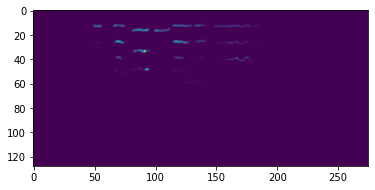

In [ ]:
# take a peek at the data
plt.imshow(pairs_train[45,0])
print(labels_train[45])

In [ ]:
from tensorflow.keras.layers import Conv2D, ZeroPadding2D, Activation, Input, concatenate, Dense,Dropout,MaxPooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Lambda
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential, Model,load_model
from tensorflow.keras.layers import Flatten, Dense, Concatenate, Dot, Lambda, Input
from tensorflow.keras.datasets import mnist
from tensorflow.keras.optimizers import Adam

In [ ]:
def get_siamese_model(input_shape):

  left_input = Input(input_shape)
  right_input = Input(input_shape)

  model = Sequential()
  model.add(Conv2D(32, (3,3), activation='relu', input_shape=input_shape))
  model.add(MaxPooling2D())
  model.add(Dropout(0.4))
  model.add(Conv2D(64, (3,3), activation='relu'))
  model.add(Dropout(0.4))
  # model.add(Conv2D(256, (2,2), activation='relu'))
  model.add(Flatten())
  model.add(Dense(256, activation='relu'))
  model.add(Dropout(0.5))
  # Generate the encodings (feature vectors) for the two images
  encoded_l = model(left_input)
  encoded_r = model(right_input)

  # Add a customized layer to compute the absolute difference between the encodings
  L1_layer = Lambda(lambda tensors:K.abs(tensors[0] - tensors[1]))
  L1_distance = L1_layer([encoded_l, encoded_r])


  # Add a dense layer with a sigmoid unit to generate the similarity score
  prediction = Dense(1,activation='sigmoid')(L1_distance)

  # Connect the inputs with the outputs
  siamese_net = Model(inputs=[left_input,right_input],outputs=prediction)

  return siamese_net

In [ ]:
model = get_siamese_model((128,275,1))
model.summary()

Model: "functional_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           [(None, 128, 275, 1) 0                                            
__________________________________________________________________________________________________
input_12 (InputLayer)           [(None, 128, 275, 1) 0                                            
__________________________________________________________________________________________________
sequential_5 (Sequential)       (None, 256)          133941888   input_11[0][0]                   
                                                                 input_12[0][0]                   
__________________________________________________________________________________________________
lambda_5 (Lambda)               (None, 256)          0           sequential_5[0][0]   

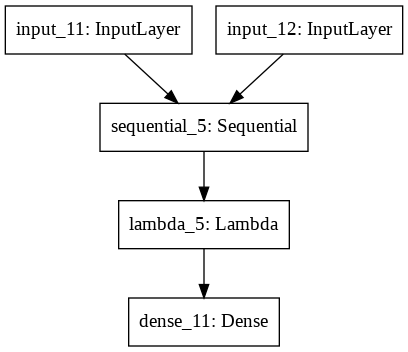

In [ ]:
from tensorflow.keras.utils import plot_model
# plot graph
plot_model(model, to_file='audio_siam.png')

In [ ]:
optimizer = Adam(lr = 0.001)
model.compile(loss="binary_crossentropy",optimizer=optimizer,metrics=["accuracy"])

In [ ]:
 history = model.fit([pairs_train[:,0], pairs_train[:,1]], labels_train[:],epochs= 80,batch_size=32,validation_data=([pairs_test[:,0], pairs_test[:,1]],labels_test[:]))

Epoch 1/80
45/45 [==============================] - 6s 123ms/step - loss: 0.6994 - accuracy: 0.4908 - val_loss: 0.6931 - val_accuracy: 0.5099
Epoch 2/80
45/45 [==============================] - 5s 119ms/step - loss: 0.6929 - accuracy: 0.5148 - val_loss: 0.6930 - val_accuracy: 0.5099
Epoch 3/80
45/45 [==============================] - 5s 119ms/step - loss: 0.6926 - accuracy: 0.5064 - val_loss: 0.6922 - val_accuracy: 0.5312
Epoch 4/80
45/45 [==============================] - 5s 120ms/step - loss: 0.6958 - accuracy: 0.4965 - val_loss: 0.6928 - val_accuracy: 0.5230
Epoch 5/80
45/45 [==============================] - 5s 119ms/step - loss: 0.6918 - accuracy: 0.5381 - val_loss: 0.6927 - val_accuracy: 0.5197
Epoch 6/80
45/45 [==============================] - 5s 120ms/step - loss: 0.6926 - accuracy: 0.5290 - val_loss: 0.6926 - val_accuracy: 0.5197
Epoch 7/80
45/45 [==============================] - 5s 120ms/step - loss: 0.6914 - accuracy: 0.5162 - val_loss: 0.6915 - val_accuracy: 0.5510
Epoch 

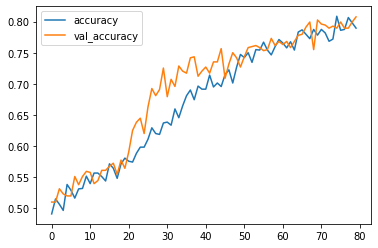

In [ ]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
plt.plot(range(len(accuracy)),accuracy,label='accuracy')
plt.plot(range(len(val_accuracy)),val_accuracy,label='val_accuracy')
plt.legend()

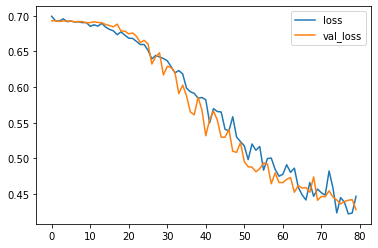

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']
plt.plot(range(len(loss)),loss,label='loss')
plt.plot(range(len(loss)),val_loss,label='val_loss')
plt.legend()

In [ ]:
model.save('audio_siam_05.h5')

# For Prediction

In [ ]:
model.predict([pairs_test[1,0].reshape(1,128,275,1), pairs_test[1,1].reshape(1,128,275,1)],labels_test[1])

array([[0.16194649]], dtype=float32)